In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')
color_pallete = ["#e27c7c", "#a86464", "#6d4b4b", "#503f3f", "#333333", "#3c4e4b", "#466964", "#599e94", "#6cd4c5"]

In [ ]:
path = r'/content/amazon_retail_50000_clean.csv'
df = pd.read_csv(path)
df.head()

,Unnamed: 0,index,order_id,date,status,fulfilment,ship_service_level,style,sku,category,...,asin,courier_status,quantity,revenue,ship_city,ship_state,ship_postal_code,promotion_ids,b2b,fulfilled_by
0,0,0,405-8078784-5731545,2022-04-30,cancelled,Merchant,Standard,SET389,SET389-KR-NP-S,Set,...,B09KXVBD7Z,Lost,0,647.62,Mumbai,Maharashtra,400081.0,NaN,False,Easy Ship
1,1,1,171-9198151-1101146,2022-04-30,shipped_delivered_to_buyer,Merchant,Standard,JNE3781,JNE3781-KR-XXXL,Kurta,...,B09K3WFS32,Shipped,1,406.00,Bengaluru,Karnataka,560085.0,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship
2,2,2,404-0687676-7273146,2022-04-30,shipped,Amazon,Expedited,JNE3371,JNE3371-KR-XL,Kurta,...,B07WV4JV4D,Shipped,1,329.00,Navi Mumbai,Maharashtra,410210.0,IN Core Free Shipping 2015/04/08 23-48-5-108,True,Other Fulfillment
3,3,3,403-9615377-8133951,2022-04-30,cancelled,Merchant,Standard,J0341,J0341-DR-L,Western Dress,...,B099NRCT7B,Lost,0,753.33,Puducherry,Puducherry,605008.0,NaN,False,Easy Ship
4,4,4,407-1069790-7240320,2022-04-30,shipped,Amazon,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,B098714BZP,Shipped,1,574.00,Chennai,Tamil Nadu,600073.0,NaN,False,Other Fulfillment


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46091 entries, 0 to 46090
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          46091 non-null  int64  
 1   index               46091 non-null  int64  
 2   order_id            46091 non-null  object 
 3   date                46091 non-null  object 
 4   status              46091 non-null  object 
 5   fulfilment          46091 non-null  object 
 6   ship_service_level  46091 non-null  object 
 7   style               46091 non-null  object 
 8   sku                 46091 non-null  object 
 9   category            46091 non-null  object 
 10  size                46091 non-null  object 
 11  asin                46091 non-null  object 
 12  courier_status      46091 non-null  object 
 13  quantity            46091 non-null  int64  
 14  revenue             46091 non-null  float64
 15  ship_city           46091 non-null  object 
 16  ship

In [ ]:
df.drop(df.columns.tolist()[:2], axis=1, inplace=True)

In [ ]:
# check the string formatting of date
print(df['date'][0])

2022-04-30


In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
print(df['date'].dtype)

datetime64[ns]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46091 entries, 0 to 46090
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            46091 non-null  object        
 1   date                46091 non-null  datetime64[ns]
 2   status              46091 non-null  object        
 3   fulfilment          46091 non-null  object        
 4   ship_service_level  46091 non-null  object        
 5   style               46091 non-null  object        
 6   sku                 46091 non-null  object        
 7   category            46091 non-null  object        
 8   size                46091 non-null  object        
 9   asin                46091 non-null  object        
 10  courier_status      46091 non-null  object        
 11  quantity            46091 non-null  int64         
 12  revenue             46091 non-null  float64       
 13  ship_city           46091 non-null  object    

## 2.1 Helper Function

### 2.1.1 Barplot data label adder

In [ ]:
def add_data_labels_to_barplot(ax, bars, fontsize=12, dtype=None):
    for bar in bars:
        height = bar.get_height()
        if dtype == 'rupees':
            if height / 1e7 > 1:
                num_label = f'₹ {height / 1e7:.2f} Cr'
            elif height / 1e5 > 1:
                num_label = f'₹ {height / 1e5:.2f} L'
            elif height / 1e3 > 1:
                num_label = f'₹ {height / 1e3:.2f} K'
            else:
                num_label = f'₹ {height:.2f}'
        elif dtype == 'percentage':
            num_label = f'{height:.2f}%'
        else:
            num_label = f'{height:.0f}'
        ax.text(
            x = bar.get_x() + bar.get_width() / 2, # center of bar along x axis
            y = height * (1.02), # little offset
            s = num_label,
            ha = 'center',
            va = 'bottom',
            fontsize = fontsize
        )
    return ax

### 2.1.2 Indian currency formatter

In [ ]:
def format_to_rupees(x):
    if not isinstance(x, (int, float)):
        return "Invalid Input"

    sign ='-' if x < 0 else ''
    x = abs(x)

    x_str = f'{x:.2f}'

    parts = x_str.split('.')
    int_part = parts[0]
    dec_part = parts[1]

    # indian logic
    last_three = int_part[-3:]
    other = int_part[:-3][::-1]

    if not other:
        formatted_int_part = last_three
    else:
        formatted_group = []
        for i in range(0, len(other), 2):
            formatted_group.append(other[i: i+2])

        formatted_int_part = ','.join(reversed(formatted_group)) + ',' + last_three

    return f'{sign}₹ {formatted_int_part}.{dec_part}'

In [ ]:
format_to_rupees(29433964.86)

'₹ 2,49,33,964.86'

## 2.2 Global KPIs

In [ ]:
global_kpis = {
    # fundamental counts
    'total_revenue': format_to_rupees(df['revenue'].sum()),
    'total_units_sold': df['quantity'].sum(),
    'total_unique_orders': df['order_id'].nunique(),

    # order value and size
    'average_order_value':  format_to_rupees(df['revenue'].sum() / df['order_id'].nunique()),
    'average_units_per_order': df['quantity'].sum() / df['order_id'].nunique(),
    'average_line_items_per_order': df.shape[0] / df['order_id'].nunique(),

    # pricing
    'average_selling_price': format_to_rupees(df['revenue'].sum() / df['quantity'].sum()),

    # b2b orders
    '%_b2b_items':  len(df.loc[df['b2b'] == True]) / len(df) * 100,

    # fulfillment
    '%_successful_delievery_rate': len(df.loc[df['status'] == 'shipped_delivered_to_buyer']) / len(df['status']) * 100,

    # loss
    '%_cancellation_rate': len(df.loc[df['status'] == 'cancelled']) / len(df['status']) * 100,
    'total_undelievered_revenue': format_to_rupees(df.loc[df['status'] != 'shipped_delivered_to_buyer']['revenue'].sum()),

    # promotions
    'total_revenue_by_promotion': format_to_rupees(df.loc[df['promotion_ids'] != 'None']['revenue'].sum()),

    # geographic
    'revenue_concentration': format_to_rupees(df['revenue'].sum() / df['ship_postal_code'].nunique())
}


pd.DataFrame.from_dict(global_kpis, orient='index', columns=['Value'])

,Value
total_revenue,"₹ 2,49,33,964.86"
total_units_sold,44116
total_unique_orders,42995
average_order_value,₹ 684.59
average_units_per_order,1.026073
average_line_items_per_order,1.072008
average_selling_price,₹ 667.19
%_b2b_items,0.748519
%_successful_delievery_rate,25.92914
%_cancellation_rate,9.307674


## 2.3 Successful deliveries

### 2.3.1 Status issues

In [ ]:
print(f'Unique status values: {df['status'].unique()}')

Unique status values: ['cancelled' 'shipped_delivered_to_buyer' 'shipped'
 'shipped_returned_to_seller' 'shipped_rejected_by_buyer'
 'shipped_out_for_delivery' 'shipped_returning_to_seller'
 'shipped_picked_up' 'pending']


`Issue`: We can see labels like **shipped** and **pending** which seem to ambiguous and overlapping with other categories.

Its possible different fulfillement channels use different statuses.

In [ ]:
print(f'Unique Fulfillment methods: {df['fulfilment'].unique()}')

Unique Fulfillment methods: ['Merchant' 'Amazon']


In [ ]:
df_amazon = df[df['fulfilment'] == 'Amazon']
df_merchant = df[df['fulfilment'] == 'Merchant']
print(f'Unique status values: {df_amazon['status'].unique()}')
print(f'\nUnique status values:\n{df_merchant['status'].unique()}')

Unique status values: ['shipped' 'cancelled' 'pending']

Unique status values:
['cancelled' 'shipped_delivered_to_buyer' 'shipped_returned_to_seller'
 'shipped_rejected_by_buyer' 'shipped_out_for_delivery'
 'shipped_returning_to_seller' 'shipped_picked_up']


In [ ]:
df_success = df[df['status'] == 'shipped_delivered_to_buyer']
print(
    f'Number of deliveries successfully delivered to buyers: {len(df_success)}',
    f'\n% Retained dataset: {len(df_success) / len(df) * 100:.2f}%',
)

Number of deliveries successfully delivered to buyers: 11951 
% Retained dataset: 25.93%


In [ ]:
success_kpis = {
    'total_revenue': format_to_rupees(df_success['revenue'].sum()),
    'total_units_sold': df_success['quantity'].sum(),
    'total_unique_orders': df_success['order_id'].nunique(),

    'average_order_value':  format_to_rupees(df_success['revenue'].sum() / df_success['order_id'].nunique()),
    'average_units_per_order': df_success['quantity'].sum() / df_success['order_id'].nunique(),
    'average_line_items_per_order': df_success.shape[0] / df_success['order_id'].nunique(),

    'average_selling_price': format_to_rupees(df_success['revenue'].sum() / df_success['quantity'].sum()),

    '%_b2b_items':  len(df_success.loc[df_success['b2b'] == True]) / len(df_success) * 100
}

pd.DataFrame.from_dict(success_kpis, orient='index', columns=['Value'])

,Value
total_revenue,"₹ 57,98,449.00"
total_units_sold,12011
total_unique_orders,10960
average_order_value,₹ 692.47
average_units_per_order,1.095894
average_line_items_per_order,1.09042
average_selling_price,₹ 631.87
%_b2b_items,1.054305


## 2.4 Product Categories

### 2.4.1 Main KPIs

In [ ]:
category_kpis = df.groupby('category').agg(
    total_revenue = ('revenue', 'sum'),
    total_units_sold = ('quantity', 'sum'),
    total_unique_orders = ('order_id', 'nunique')
)

category_kpis['average_order_value'] = category_kpis['total_revenue'] / category_kpis['total_unique_orders']
category_kpis['average_selling_price'] = category_kpis['total_revenue'] / category_kpis['total_units_sold']

# !!! For plotting we want numbers to remain in float
# cols_to_format = ['total_revenue', 'average_order_value', 'average_selling_price']
# for col in cols_to_format:
#     category_kpis[col] = category_kpis[col].apply(format_to_rupees)
category_kpis.sort_values(by='total_revenue', ascending = False)

,total_revenue,total_units_sold,total_unique_orders,average_order_value,average_selling_price
category,,,,,
Set,15770971.17,18032,17864,882.835377,874.610202
Kurta,8154385.72,17571,17235,473.129430,464.082051
Western Dress,3058761.87,3884,3910,782.292038,787.528803
Top,1869544.55,3698,3654,511.643281,505.555584
Ethnic Dress,262956.65,322,339,775.683333,816.635559
Blouse,198381.21,378,382,519.322539,524.818016
Bottom,63308.45,163,161,393.220186,388.395399
Saree,55655.24,68,58,959.573103,818.459412


### 2.4.2 Plots

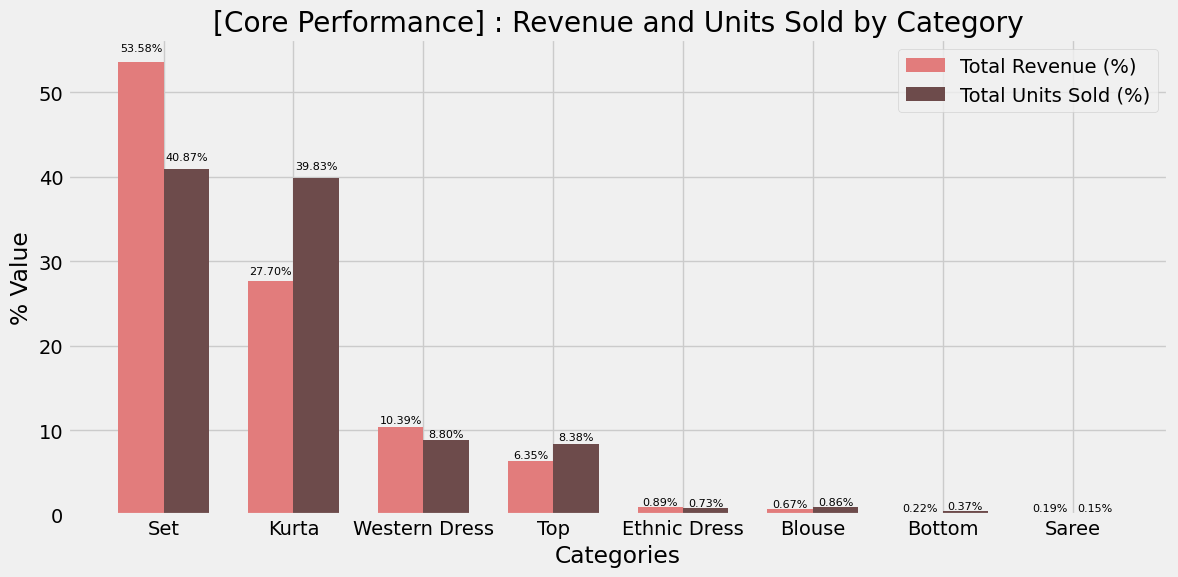

In [ ]:
fig = plt.figure(figsize=(12,6), tight_layout=True)
ax = fig.add_subplot(1,1,1)

bar_width=0.35
x = np.arange(len(category_kpis))

sorted_data = category_kpis.sort_values(by='total_revenue', ascending=False)

bars = ax.bar(
    x=x-bar_width/2,
    height=sorted_data['total_revenue'] / sorted_data['total_revenue'].sum() * 100,
    color=color_pallete[0],
    width=bar_width,
    label='Total Revenue (%)'
)
ax = add_data_labels_to_barplot(ax, bars, fontsize=8, dtype='percentage')

bars = ax.bar(
    x=x+bar_width/2,
    height=sorted_data['total_units_sold'] / sorted_data['total_units_sold'].sum() * 100,
    color=color_pallete[2],
    width=bar_width,
    label = 'Total Units Sold (%)'
)
ax = add_data_labels_to_barplot(ax, bars, fontsize=8, dtype='percentage')

ax.set_xlabel('Categories')
ax.set_ylabel('% Value')
ax.set_title('[Core Performance] : Revenue and Units Sold by Category')
ax.set_xticks(x)
ax.set_xticklabels(sorted_data.index)
ax.legend();

`Observations`:
- **SET**: Highest revenue contribution and total units sold.
    - *Action*: Maximize profitiblity and market share
- **KURTA**: High volume driver, with almost half the revenue contribution to **SET** it has similar units sold.
    - *Action*: Testing should be done to increase the prices without losing units sold.


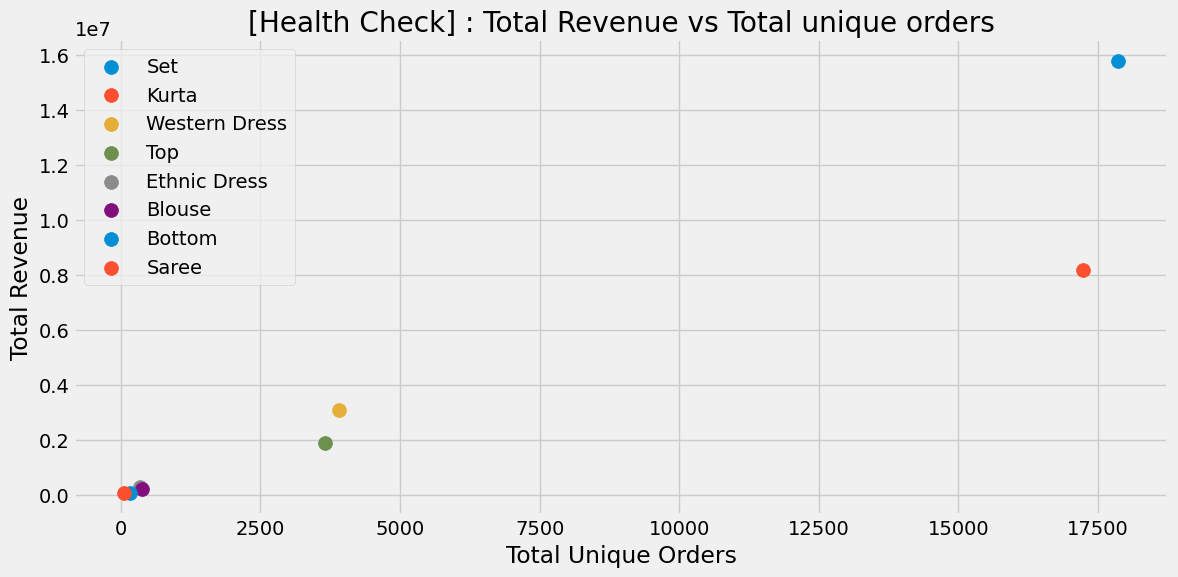

In [ ]:
fig = plt.figure(figsize=(12,6), tight_layout=True)
ax = fig.add_subplot(1,1,1)

for i, category in enumerate(sorted_data.index):
    ax.scatter(
        x = sorted_data.loc[sorted_data.index== category, 'total_unique_orders'],
        y = sorted_data.loc[sorted_data.index == category, 'total_revenue'],
        label = category,
        s = 100
    )

ax.set_xlabel('Total Unique Orders')
ax.set_ylabel('Total Revenue')
ax.set_title('[Health Check] : Total Revenue vs Total unique orders')
ax.legend();

`Observations`:
- **Top-right Quadrant**: **SET** is the cash cow of the company.
- **Bottom-right Quadrant**: **KURTA** is the high order driver.
- **Bottom-left Quadrant**: Extrememly niche products

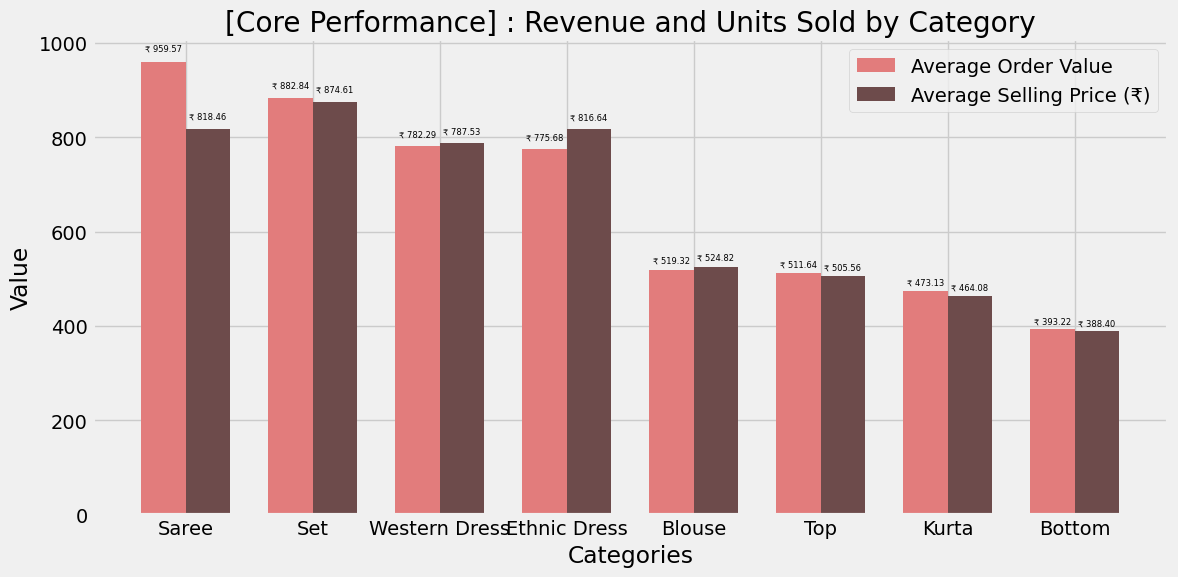

In [ ]:
fig = plt.figure(figsize=(12,6), tight_layout=True)
ax = fig.add_subplot(1,1,1)

bar_width=0.35
x = np.arange(len(category_kpis))

sorted_data = category_kpis.sort_values(by='average_order_value', ascending=False)

bars = ax.bar(
    x=x-bar_width/2,
    height=sorted_data['average_order_value'],
    color=color_pallete[0],
    width=bar_width,
    label='Average Order Value'
)
ax = add_data_labels_to_barplot(ax, bars, fontsize=6, dtype='rupees')

bars = ax.bar(
    x=x+bar_width/2,
    height=sorted_data['average_selling_price'],
    color=color_pallete[2],
    width=bar_width,
    label = 'Average Selling Price (₹)'
)
ax = add_data_labels_to_barplot(ax, bars, fontsize=6, dtype='rupees')

ax.set_xlabel('Categories')
ax.set_ylabel('Value')
ax.set_title('[Core Performance] : Revenue and Units Sold by Category')
ax.set_xticks(x)
ax.set_xticklabels(sorted_data.index)
ax.legend();

`Observations`:
- **SAREE**: Extremely niche product with high ASP and AOV.
    - *Action*: Invest in promotions to increase sales numbers.
- **SET**: Most signficant product with high revenue contribution, units sold, ASP and AOV.
    - *Action*: Maximize profitablity and increase market share.
- **WESTERN DRESS**: Potential product for secondary or tertiary investement with relatively high evenue contribution, units sold, ASP and AOV.

### 2.4.3 Operational KPIs

In [ ]:
status_delivered = 'shipped_delivered_to_buyer'
status_strictly_cancelled = ['cancelled', 'shipped_rejected_by_buyer', 'shipped_returned_to_seller']

category_operation_kpis = df.groupby('category').agg(
    total_line_items = ('order_id', 'count'),
    total_unique_orders = ('order_id', 'nunique'),
    delivered_items = ('status', lambda x: (x == status_delivered).sum()),
    strict_loss_items = ('status', lambda x: (x.isin(status_strictly_cancelled).sum()))
)
category_operation_kpis

,total_line_items,total_unique_orders,delivered_items,strict_loss_items
category,,,,
Blouse,394,382,91,47
Bottom,168,161,30,13
Ethnic Dress,339,339,90,36
Kurta,18458,17235,5029,2195
Saree,73,58,13,8
Set,18801,17864,4646,2103
Top,3794,3654,692,344
Western Dress,4064,3910,1360,430


In [ ]:
category_operation_kpis['%_delivery_success_rate'] = (
    category_operation_kpis['delivered_items'] / category_operation_kpis['total_line_items'] * 100
)
category_operation_kpis['%_strict_loss_rate'] = (
    category_operation_kpis['strict_loss_items'] / category_operation_kpis['total_line_items'] * 100
)
category_operation_kpis['%_in_pipeline_rate'] = (
    100 - category_operation_kpis['%_delivery_success_rate'] - category_operation_kpis['%_strict_loss_rate']
)
category_operation_kpis

,total_line_items,total_unique_orders,delivered_items,strict_loss_items,%_delivery_success_rate,%_strict_loss_rate,%_in_pipeline_rate
category,,,,,,,
Blouse,394,382,91,47,23.096447,11.928934,64.974619
Bottom,168,161,30,13,17.857143,7.738095,74.404762
Ethnic Dress,339,339,90,36,26.548673,10.619469,62.831858
Kurta,18458,17235,5029,2195,27.245639,11.891863,60.862499
Saree,73,58,13,8,17.808219,10.958904,71.232877
Set,18801,17864,4646,2103,24.711452,11.185575,64.102973
Top,3794,3654,692,344,18.239325,9.066948,72.693727
Western Dress,4064,3910,1360,430,33.464567,10.580709,55.954724


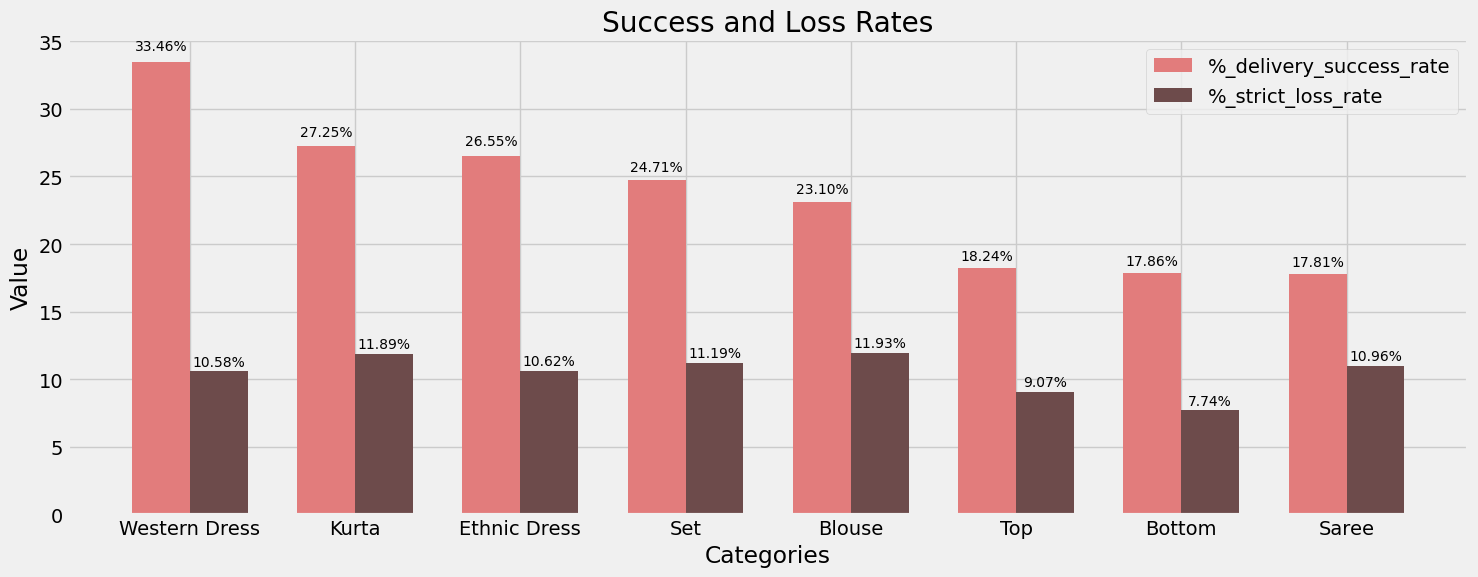

In [ ]:
fig = plt.figure(figsize=(15,6), tight_layout=True)
ax = fig.add_subplot(1,1,1)

bar_width=0.35
x = np.arange(len(category_operation_kpis))

sorted_data = category_operation_kpis.sort_values(by='%_delivery_success_rate', ascending=False)

for i in range(2):
    if i == 0:
        x_point = x - bar_width / 2
    else:
        x_point = x + bar_width / 2

    bars = ax.bar(
        x=x_point,
        height=sorted_data.iloc[:, -3+i],
        color=color_pallete[i*2],
        width=bar_width,
        label = sorted_data.columns[-3+i]
    )
    ax = add_data_labels_to_barplot(ax, bars, fontsize=10, dtype='percentage')

ax.set_xlabel('Categories')
ax.set_ylabel('Value')
ax.set_title('Success and Loss Rates')
ax.set_xticks(x)
ax.set_xticklabels(sorted_data.index)
ax.legend();

`Observations`:
- **WESTERN DRESS, KURTA & SET**: Top perform products with high success delivery rates.
- **SAREE**: Niche product with high AOV and ASP but less succesful delieveries and relatively comparable loss rate.

### 2.4.4 Further Champions Analysis

In [ ]:
print(f'Ways of fulfillements: {df["fulfilment"].unique()}')

Ways of fulfillements: ['Merchant' 'Amazon']


In [ ]:
champ_categories_df = df[df['category'].isin(['Set', 'Kurta', 'Western Dress'])]

champ_category_operation_kpis = champ_categories_df.groupby('category').agg(
    fulfilled_by_merchant = ('fulfilment', lambda x: (x == 'Merchant').sum()),
    fulfilled_by_amazon = ('fulfilment', lambda x: (x == 'Amazon').sum())
)
champ_category_operation_kpis

,fulfilled_by_merchant,fulfilled_by_amazon
category,,
Kurta,6367,12091
Set,5856,12945
Western Dress,1640,2424


In [ ]:
channel_categories_kpis = champ_categories_df.groupby(['category', 'fulfilment']).agg(
    total_line_items = ('order_id', 'count'),
    delivered_items = ('status', lambda x: np.sum(x == status_delivered)),
    strict_loss_items = ('status', lambda x: np.sum(x.isin(status_strictly_cancelled)))
)

channel_categories_kpis

total_line_items  delivered_items  strict_loss_items
category      fulfilment                                                      
Kurta         Amazon                 12091                0                858
              Merchant                6367             5029               1337
Set           Amazon                 12945                0                898
              Merchant                5856             4646               1205
Western Dress Amazon                  2424                0                152
              Merchant                1640             1360                278

In [ ]:
channel_categories_kpis.to_dict()

{'total_line_items': {('Kurta', 'Amazon'): 12091,
  ('Kurta', 'Merchant'): 6367,
  ('Set', 'Amazon'): 12945,
  ('Set', 'Merchant'): 5856,
  ('Western Dress', 'Amazon'): 2424,
  ('Western Dress', 'Merchant'): 1640},
 'delivered_items': {('Kurta', 'Amazon'): 0,
  ('Kurta', 'Merchant'): 5029,
  ('Set', 'Amazon'): 0,
  ('Set', 'Merchant'): 4646,
  ('Western Dress', 'Amazon'): 0,
  ('Western Dress', 'Merchant'): 1360},
 'strict_loss_items': {('Kurta', 'Amazon'): 858,
  ('Kurta', 'Merchant'): 1337,
  ('Set', 'Amazon'): 898,
  ('Set', 'Merchant'): 1205,
  ('Western Dress', 'Amazon'): 152,
  ('Western Dress', 'Merchant'): 278}}

In [ ]:
df['date'].max() - df['date'].min()

Timedelta('61 days 00:00:00')

In [ ]:
# Filter the DataFrame for Amazon Fulfillment
amazon_df = df[df['fulfilment'] == 'Amazon']

# Find all unique statuses used by Amazon
print(f"Amazon Fulfillment Statuses:\n{amazon_df['status'].unique().tolist()}")

# check all unique items in status
print(f'\nFulfillment statuses:\n{df['status'].unique()}')

Amazon Fulfillment Statuses:
['shipped', 'cancelled', 'pending']

Fulfillment statuses:
['cancelled' 'shipped_delivered_to_buyer' 'shipped'
 'shipped_returned_to_seller' 'shipped_rejected_by_buyer'
 'shipped_out_for_delivery' 'shipped_returning_to_seller'
 'shipped_picked_up' 'pending']
